In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect
import glob
plt.rcParams["figure.figsize"] = (10,10)

In [36]:
path = "k_4.png"

In [37]:
def to_RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [38]:
def get_edges(img_gray):
    CANNY_THRESHOLD1 = 100
    CANNY_THRESHOLD2 = 200
    return cv2.Canny(img_gray, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

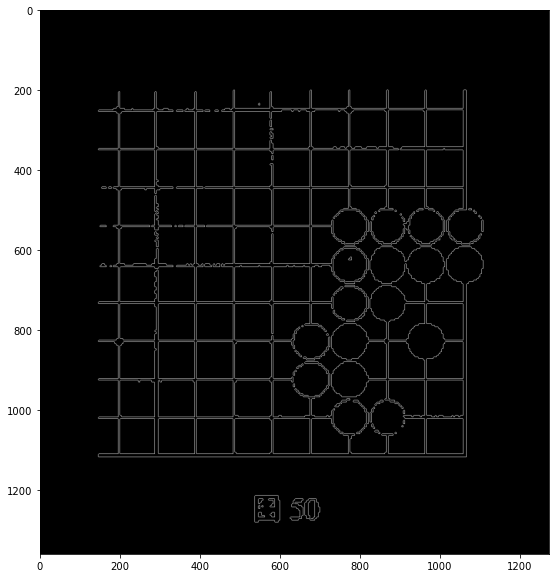

In [39]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
edges = get_edges(img_gray)
plt.imshow(to_RGB(edges))
plt.show() 

In [40]:
def all_lines(img_gray, hough_threshold):
        HOUGH_RHO = 1
        HOUGH_THETA = np.pi / 180

        edges = get_edges(img_gray)
        size = min(img_gray.shape[0:2])
        lines = cv2.HoughLinesP(edges, rho=HOUGH_RHO, theta=HOUGH_THETA, threshold=hough_threshold,
                                minLineLength=size / 2, maxLineGap=size)  ### ?
        if lines is None:
            return None
        return np.reshape(lines, (lines.shape[0], lines.shape[2]))

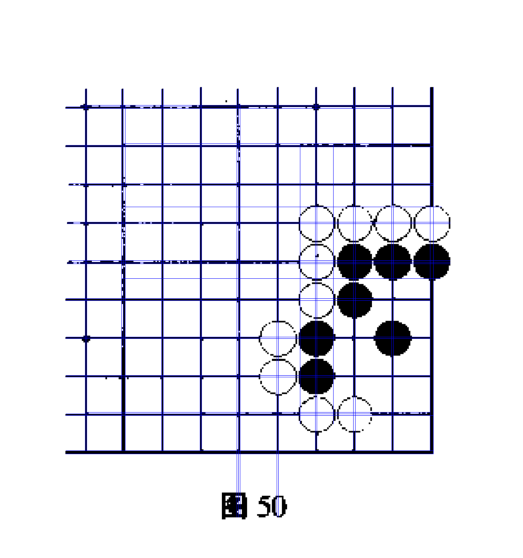

In [41]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
lines = all_lines(img_gray, 100)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [42]:
def get_verticals_horizontals(img_gray, hough_threshold):
        VERTICAL_TAN_MIN = 50
        HORIZONTAL_TAN_MAX = 0.02

        # Find all lines
        lines = all_lines(img_gray, hough_threshold)
        if (lines is None):
            return [], []
        # Divide the lines into verticals and horizontals
        v_lines = []
        h_lines = []
        for line in lines:
            x1, y1, x2, y2 = line
            if x1 == x2:
                if (y1 > y2):
                    line[0] = x2
                    line[1] = y2
                    line[2] = x1
                    line[3] = y1
                v_lines.append(line)
            else:
                slope = (y2 - y1) / (x2 - x1)
                if abs(slope) > VERTICAL_TAN_MIN:
                    if (y1 > y2):
                        line[0] = x2
                        line[1] = y2
                        line[2] = x1
                        line[3] = y1
                elif abs(slope) < HORIZONTAL_TAN_MAX:
                    if (x1 > x2):
                        line[0] = x2
                        line[1] = y2
                        line[2] = x1
                        line[3] = y1
                    h_lines.append(line)
        v_lines = np.array(v_lines)
        h_lines = np.array(h_lines)
        # Merge close lines
        return merge_lines(merge_lines(v_lines, True), True), merge_lines(merge_lines(h_lines, False), False)

In [43]:
def merge_lines(lines, is_vertical):
    
    # ???
        MIN_DIST = 10

        close_groups = []
        grouped = set()
        for i in range(lines.shape[0]):
            if i in grouped:
                continue
            close_groups.append([i])
            grouped.add(i)
            for j in set(range(i + 1, lines.shape[0])) - grouped:
                x1_i, y1_i, x2_i, y2_i = lines[i]
                x1_j, y1_j, x2_j, y2_j = lines[j]
                if is_vertical:
                    dist = min(abs(x1_i - x1_j), abs(x2_i - x2_j))
                else:
                    dist = min(abs(y1_i - y1_j), abs(y2_i - y2_j))
                if (dist <= MIN_DIST):
                    close_groups[-1].append(j)
                    grouped.add(j)
        merged_lines = []
        for group in close_groups:
            line_group = lines[group]
            if is_vertical:
                x = round(np.mean(line_group[:, [0, 2]]))
                merged_line = (x, np.amin(line_group[:, 1]), x, np.amax(line_group[:, 3]))
            else:
                y = round(np.mean(line_group[:, [1, 3]]))
                merged_line = (np.amin(line_group[:, 0]), y, np.amax(line_group[:, 2]), y)
            merged_lines.append(merged_line)

        if is_vertical:
            return np.array(sorted(merged_lines, key=lambda line: line[0]))
        else:
            return np.array(sorted(merged_lines, key=lambda line: line[1]))

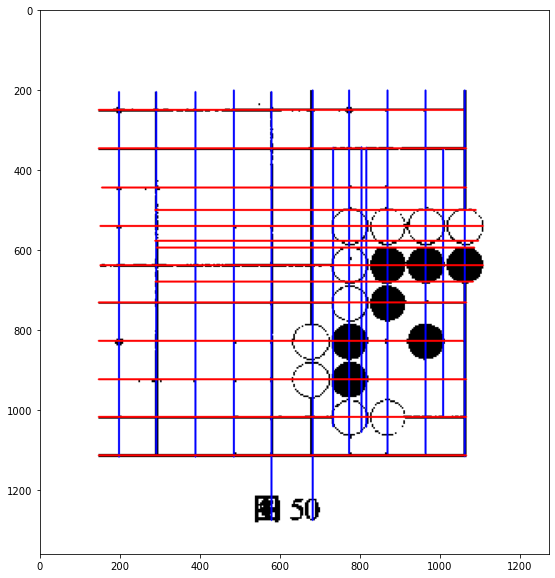

In [44]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
v_lines, h_lines =  get_verticals_horizontals(img_gray, 50)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
plt.imshow(to_RGB(img))
plt.show() 

In [45]:
def lines_recognition(img_gray):
        HOUGH_LOW_THRESHOLD = 50
        MIN_LINES_DIST_COEFF = 0.8
        MAX_LINES_DIST_COEFF = 1.2
        MIN_GAP_COEFF = 1.7
        clear_v_lines, clear_h_lines = [], []
        hough_threshold = min(img_gray.shape[0:2])
        while hough_threshold > 0:
            clear_v_lines, clear_h_lines = get_verticals_horizontals(img_gray, hough_threshold)
            if ((len(clear_v_lines) > 1) and (len(clear_h_lines) > 1)):
                cell_size_1 = np.amin(np.diff(clear_v_lines[:, 0]))
                cell_size_2 = np.amin(np.diff(clear_h_lines[:, 1]))
                cell_size = min(cell_size_1, cell_size_2)
                if (cell_size / max(cell_size_1, cell_size_2) > 0.9):
                    break
            hough_threshold -= 10
        unclear_v_lines, unclear_h_lines = get_verticals_horizontals(img_gray, HOUGH_LOW_THRESHOLD)
        # Filter unclear lines
        v_lines = [clear_v_lines[0]]
        h_lines = [clear_h_lines[0]]
        ind = bisect(unclear_v_lines[:, 0], clear_v_lines[0][0])
        for i in range(ind - 1, -1, -1):
            dist_coeff = (v_lines[-1][0] - unclear_v_lines[i][0]) / cell_size
            if MAX_LINES_DIST_COEFF > dist_coeff > MIN_LINES_DIST_COEFF:
                v_lines.append(unclear_v_lines[i])
            if dist_coeff > MIN_GAP_COEFF:
                x = (unclear_v_lines[i][0] + v_lines[-1][0]) // 2
                new_v_line = [x, v_lines[-1][1], x, v_lines[-1][3]]
                v_lines.append(new_v_line)
                v_lines.append(unclear_v_lines[i])
        v_lines.reverse()
        for i in range(ind, len(unclear_v_lines)):
            dist_coeff = (unclear_v_lines[i][0] - v_lines[-1][0]) / cell_size
            if MAX_LINES_DIST_COEFF > dist_coeff > MIN_LINES_DIST_COEFF:
                v_lines.append(unclear_v_lines[i])
            if dist_coeff > MIN_GAP_COEFF:
                x = (unclear_v_lines[i][0] + v_lines[-1][0]) // 2
                new_v_line = [x, v_lines[-1][1], x, v_lines[-1][3]]
                v_lines.append(new_v_line)
                v_lines.append(unclear_v_lines[i])
        ind = bisect(unclear_h_lines[:, 1], clear_h_lines[0][1])
        for i in range(ind - 1, -1, -1):
            dist_coeff = (h_lines[-1][1] - unclear_h_lines[i][1]) / cell_size
            if MAX_LINES_DIST_COEFF > dist_coeff > MIN_LINES_DIST_COEFF:
                h_lines.append(unclear_h_lines[i])
            if dist_coeff > MIN_GAP_COEFF:
                y = (unclear_h_lines[i][1] + h_lines[-1][1]) // 2
                new_h_line = [h_lines[-1][0], y, h_lines[-1][2], y]
                h_lines.append(new_h_line)
                h_lines.append(unclear_h_lines[i])
        h_lines.reverse()
        for i in range(ind, len(unclear_h_lines)):
            dist_coeff = (unclear_h_lines[i][1] - h_lines[-1][1]) / cell_size
            if MAX_LINES_DIST_COEFF > dist_coeff > MIN_LINES_DIST_COEFF:
                h_lines.append(unclear_h_lines[i])
            if dist_coeff > MIN_GAP_COEFF:
                y = (unclear_h_lines[i][1] + h_lines[-1][1]) // 2
                new_h_line = [h_lines[-1][0], y, h_lines[-1][2], y]
                h_lines.append(new_h_line)
                h_lines.append(unclear_h_lines[i])
        return np.array(v_lines), np.array(h_lines)

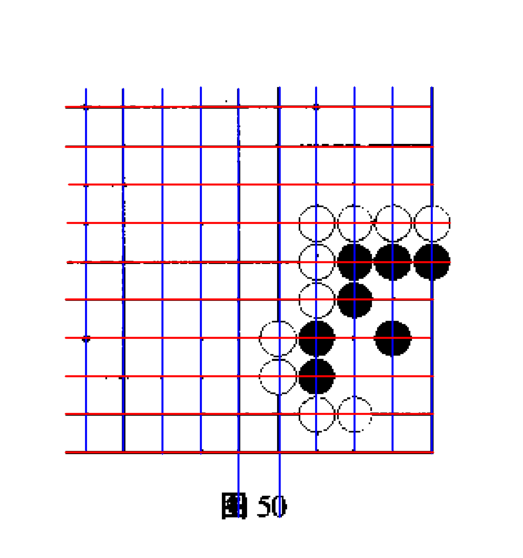

In [46]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
v_lines, h_lines = lines_recognition(img_gray)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [47]:
def get_cell_size(v_lines, h_lines):
    return round(np.mean([round(np.ptp(v_lines[:, 0]) / (v_lines.shape[0] - 1)),
                          round(np.ptp(h_lines[:, 1]) / (h_lines.shape[0] - 1))]))

In [48]:
def find_intersections(v_lines, h_lines):
    return np.array(np.meshgrid(v_lines[:, 0], h_lines[:, 1])).T

In [49]:
def find_edges(v_lines, h_lines, cell_size):
        #????
        MIN_DIFF = 0.2

        up_line = h_lines[0]
        up_edge = np.sum(up_line[1] - v_lines[:, 1] > cell_size * MIN_DIFF) < (v_lines.shape[0] / 1.5)

        down_line = h_lines[-1]
        #print(v_lines[:, 3] - down_line[1] > MIN_DIFF)
        down_edge = np.sum(v_lines[:, 3] - down_line[1] > cell_size * MIN_DIFF) < (v_lines.shape[0] / 1.5)

        left_line = v_lines[0]
        left_edge = np.sum(left_line[0] - h_lines[:, 0] > cell_size * MIN_DIFF) < (h_lines.shape[0] / 1.5)

        right_line = v_lines[-1]
        #print(h_lines[:, 2] - right_line[0] > MIN_DIFF)
        right_edge = np.sum(h_lines[:, 2] - right_line[0] > cell_size * MIN_DIFF) < (h_lines.shape[0] / 1.5)
        return up_edge, down_edge, left_edge, right_edge

In [50]:
intersections = find_intersections(v_lines, h_lines)

In [51]:
cell_size = get_cell_size(v_lines, h_lines)
cell_size

96

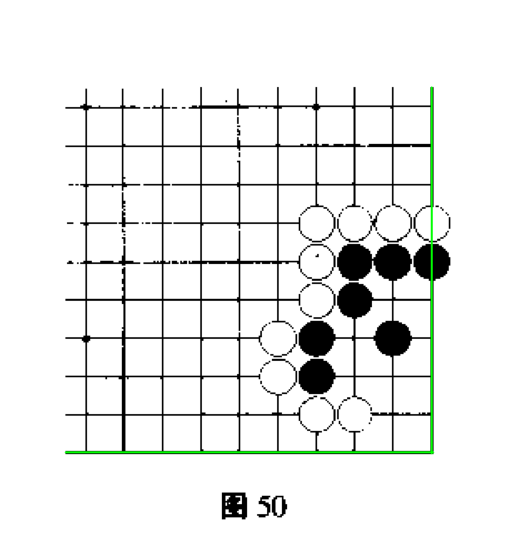

In [52]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
up_edge, down_edge, left_edge, right_edge = find_edges(v_lines, h_lines, cell_size)
if up_edge:
    line = h_lines[0]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
if down_edge:
    line = h_lines[-1]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
if left_edge:
    line = v_lines[0]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
if right_edge:
    line = v_lines[-1]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [53]:
def find_circles(img_gray, param2, min_dist_coeff, min_r_coeff, max_r_coeff, cell_size):
        METHOD = cv2.HOUGH_GRADIENT
        DP = 2
        PARAM1 = 200

        circles = cv2.HoughCircles(img_gray, method=METHOD, dp=DP,
                                minDist=round(cell_size * min_dist_coeff),
                                param1=PARAM1, param2=param2, minRadius=round(cell_size * min_r_coeff),
                                maxRadius=round(cell_size * max_r_coeff))
        if circles is None:
            return None
        return circles[0, :]

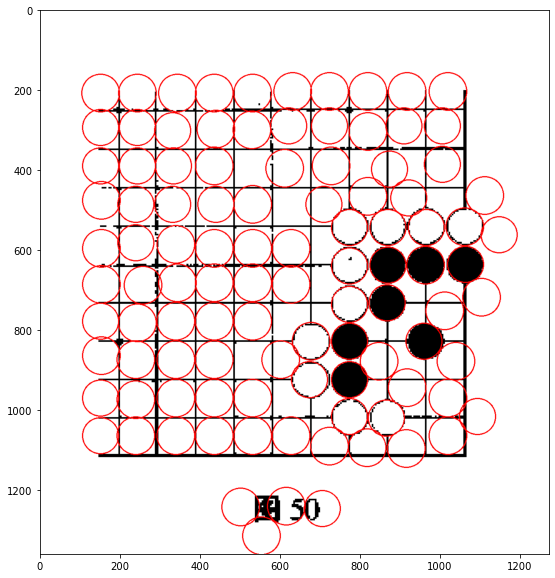

In [71]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
circles = find_circles(img_gray, 5, 0.9, 0.45, 0.5, cell_size)

img = cv2.imread(path, cv2.IMREAD_COLOR)
for circle in circles:
    cv2.circle(img ,(circle[0],circle[1]), round(circle[2]),(0,0,255),2)

plt.imshow(to_RGB(img))
plt.show()

In [83]:
def stones_recognition(img_gray, cell_size, intersections):
        MIN_INTERSECTION_DIST_COEFF = 0.15
        
        all_circles = []
        param2_grid = np.linspace(5, 30, 5)
        min_dist_coeff_grid = np.linspace(0.9, 1, 2)
        min_r_coeff_grid = np.linspace(0.4, 0.45, 2)
        max_r_coeff_grid = np.linspace(0.5, 0.55, 2)
        grid = np.array(np.meshgrid(param2_grid,
                                    min_dist_coeff_grid,
                                    min_r_coeff_grid,
                                    max_r_coeff_grid)
                       ).T.reshape(-1,4)
        for param2,min_dist_coeff,min_r_coeff, max_r_coeff  in grid:
            circles = find_circles(img_gray,param2,min_dist_coeff,min_r_coeff, max_r_coeff, cell_size)
            if circles is not None:
                all_circles.append(circles)
        circles = np.concatenate(all_circles)
        # Filter circles
        stones = []
        radii = []
        for circle in circles:
            in_intersection = False
            for intersection in np.reshape(intersections, (-1, 2)):
                if (np.linalg.norm(circle[:2] - intersection) <= MIN_INTERSECTION_DIST_COEFF * cell_size):
                    in_intersection = True
                    break
            if in_intersection:
                stones.append(intersection)
                radii.append(circle[2])
        return np.unique(stones, axis=0), round(np.mean(radii))

In [84]:
def colorize(img_gray, stones, radius):
    WHITE_THRESHOLD = 240
    BLACK_THRESHOLD = 5
    white_stones = []
    black_stones = []
    for stone in stones:
        average_color = np.mean(img_gray[stone[1] - radius//2 : stone[1] + radius//2,
                                         stone[0] - radius//2 : stone[0] + radius//2])
        if average_color >= WHITE_THRESHOLD:
            white_stones.append(stone)
        elif average_color <= BLACK_THRESHOLD:
            black_stones.append(stone)
    return np.array(white_stones), np.array(black_stones)

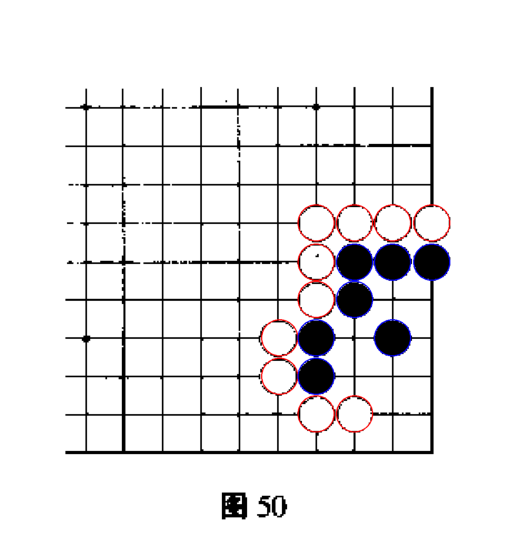

In [85]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
stones, radius = stones_recognition(img_gray, cell_size, intersections)
white_stones, black_stones = colorize(img_gray, stones, radius)

img = cv2.imread(path, cv2.IMREAD_COLOR)
for stone in white_stones:
    cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),2)
for stone in black_stones:
    cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),2)

plt.imshow(to_RGB(img))
plt.axis('off')
plt.show()

In [86]:
import sys  
sys.path.insert(0, './src')

In [87]:
import recognizer
r = recognizer.Recognizer()

In [88]:
def visualize(img):
    try:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        v_lines, h_lines = lines_recognition(img_gray)
        intersections = find_intersections(v_lines, h_lines)
        cell_size = get_cell_size(v_lines, h_lines)
        edges = find_edges(v_lines, h_lines, cell_size)
        stones, radius = stones_recognition(img_gray, cell_size, intersections)
        white_stones, black_stones = colorize(img_gray, stones, radius)
        
        for intersection in np.reshape(intersections, (-1, 2)):
            cv2.circle(img, (intersection[0], intersection[1]), 5, (255,0,255), -1)
            
        up_edge, down_edge, left_edge, right_edge = edges
        if up_edge:
            for intersection in intersections[:, 0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if down_edge:
            for intersection in intersections[:, -1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if left_edge:
            for intersection in intersections[0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if right_edge:
            for intersection in intersections[-1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        
        for stone in white_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),3)
        for stone in black_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),3)
        plt.subplot(1, 2, 2)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        plt.show()
    except:
        print("error")

In [89]:
def visualize_r(img, r):
    try:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        intersections, white_stones, black_stones, radius, x_size, y_size, edges = r.recognize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        
        for intersection in np.reshape(intersections, (-1, 2)):
            cv2.circle(img, (intersection[0], intersection[1]), 5, (255,0,255), -1)
            
        up_edge, down_edge, left_edge, right_edge = edges
        if up_edge:
            for intersection in intersections[:, 0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if down_edge:
            for intersection in intersections[:, -1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if left_edge:
            for intersection in intersections[0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if right_edge:
            for intersection in intersections[-1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        
            
        for stone in white_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),3)
        for stone in black_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),3)
        plt.subplot(1, 2, 2)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(e)

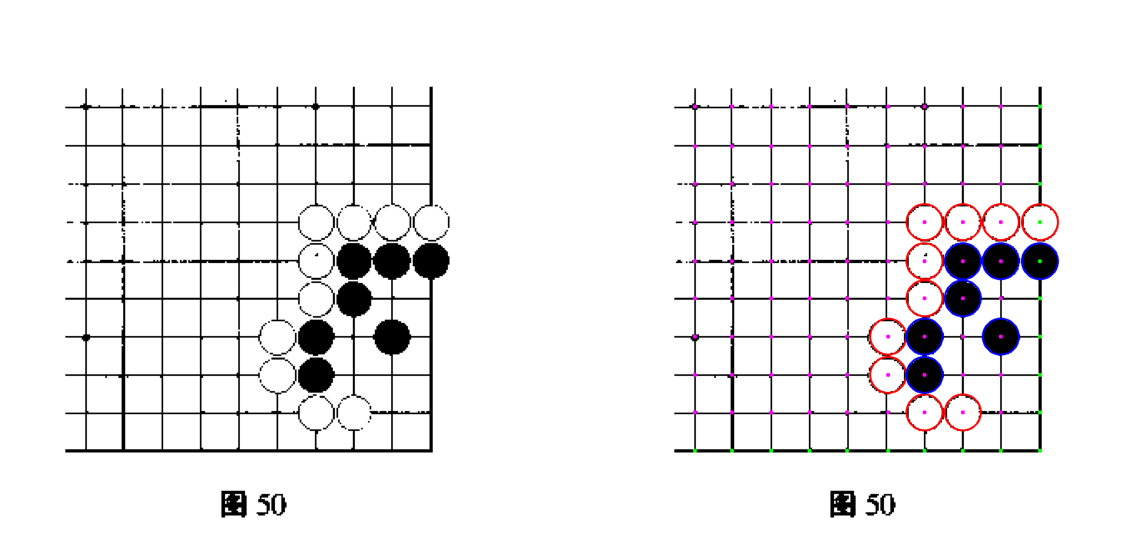

In [90]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
visualize(img)

k_10.png


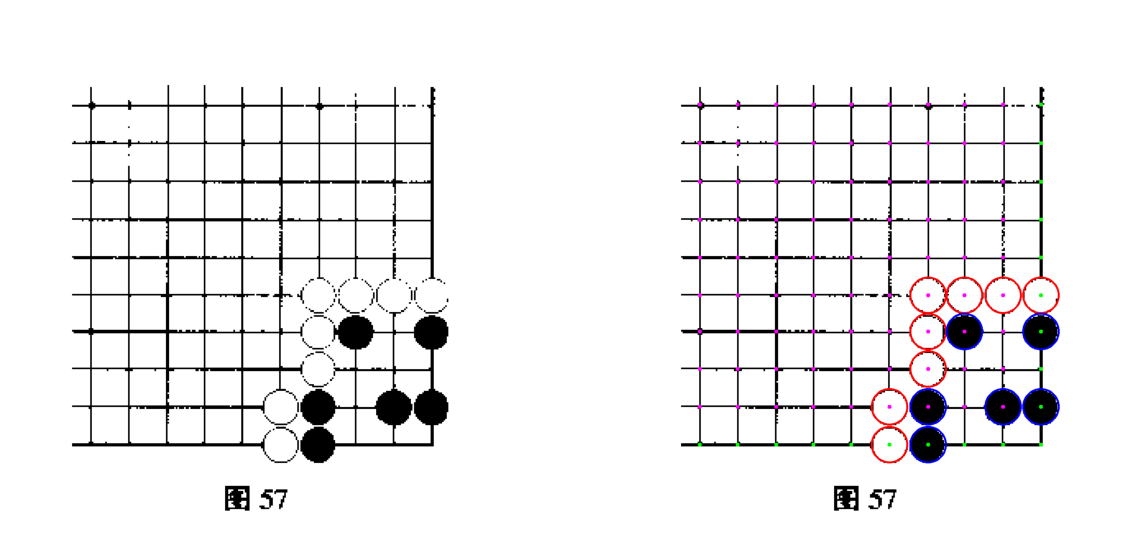

k_11.png


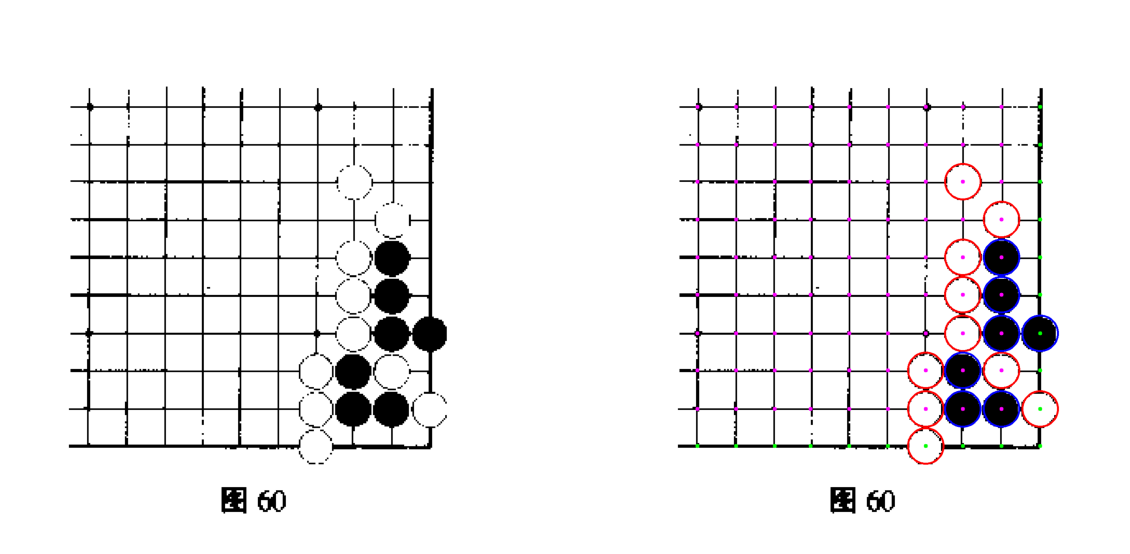

k_8.png


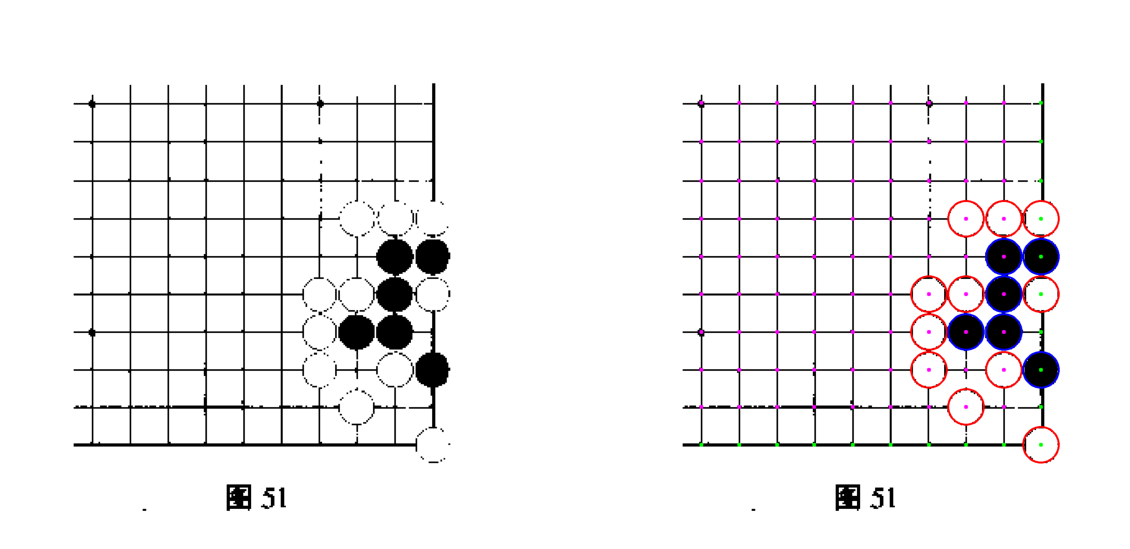

k_9.png


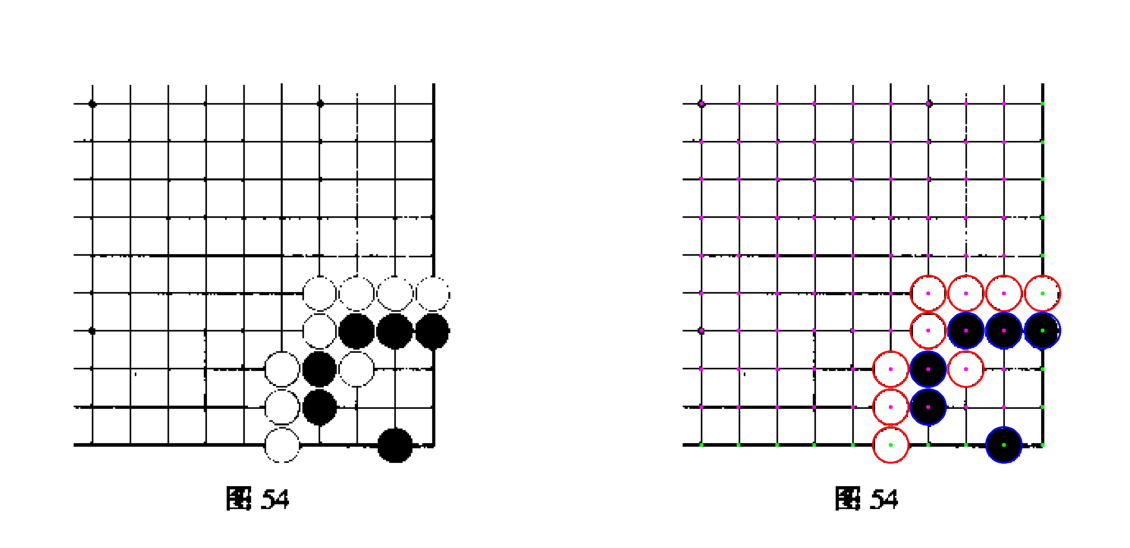

k_4.png


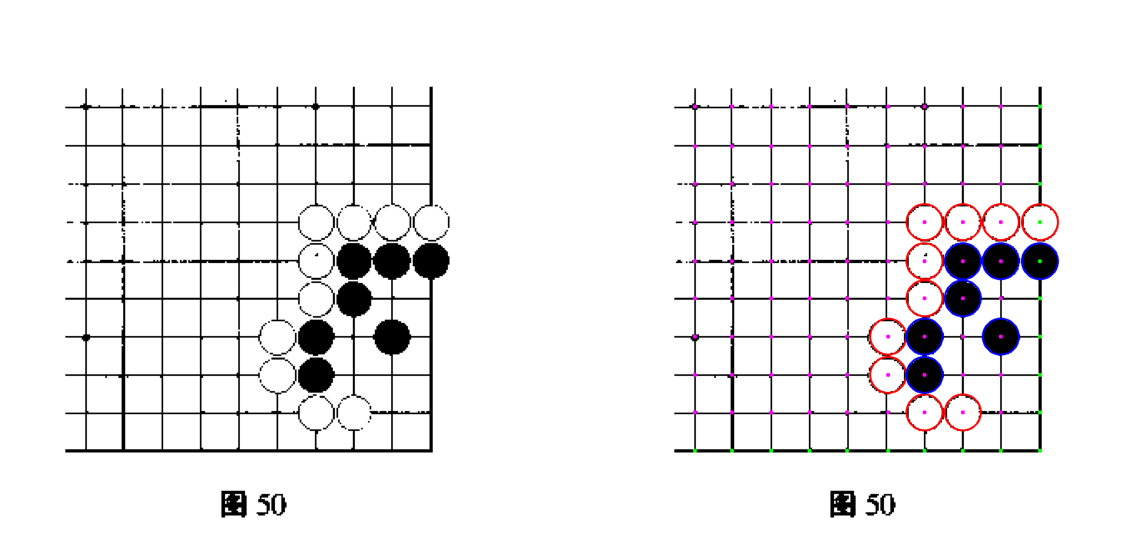

k_5.png


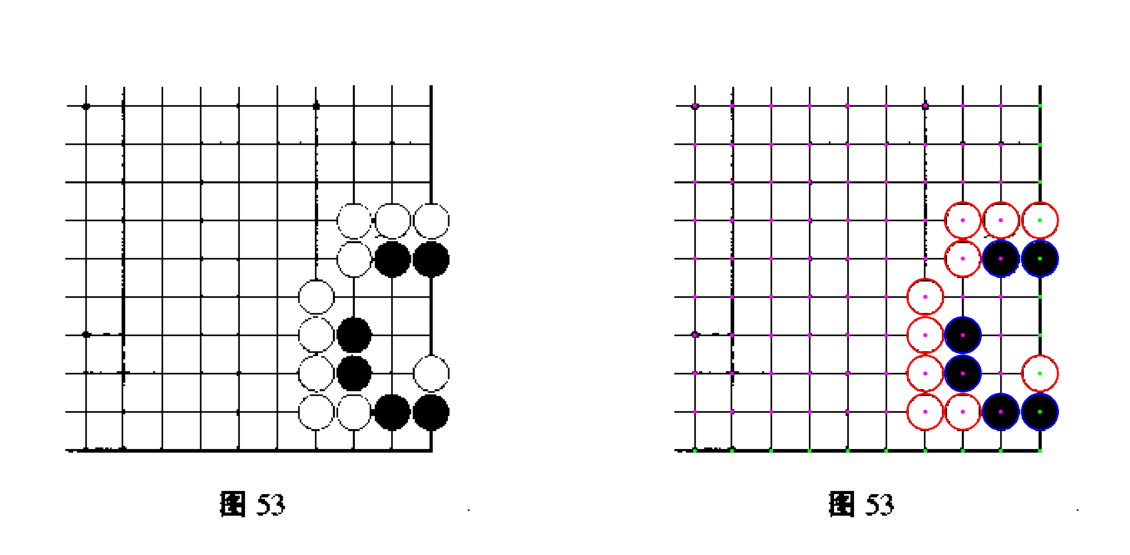

k_7.png


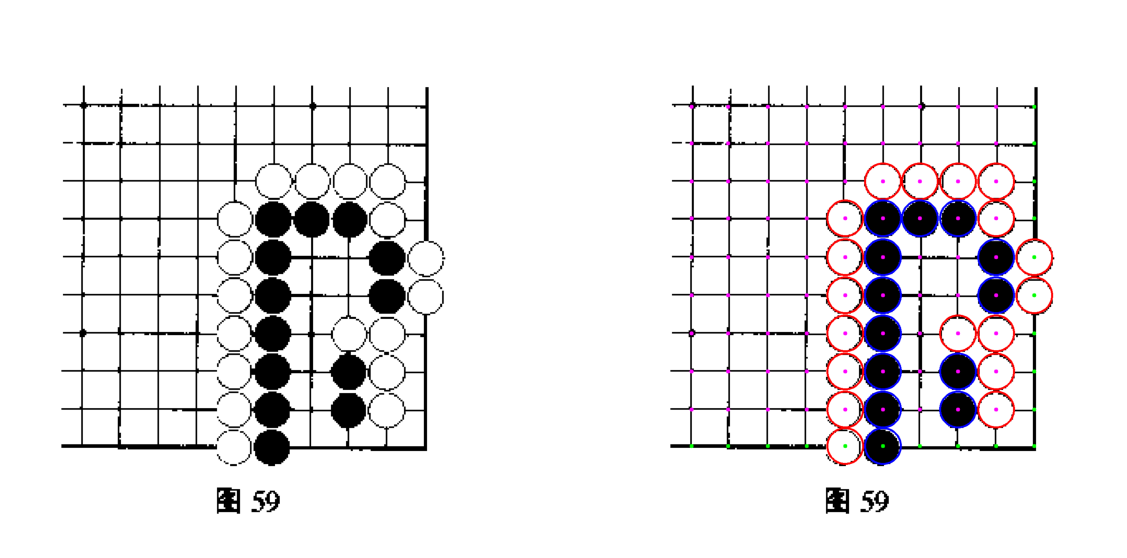

k_6.png


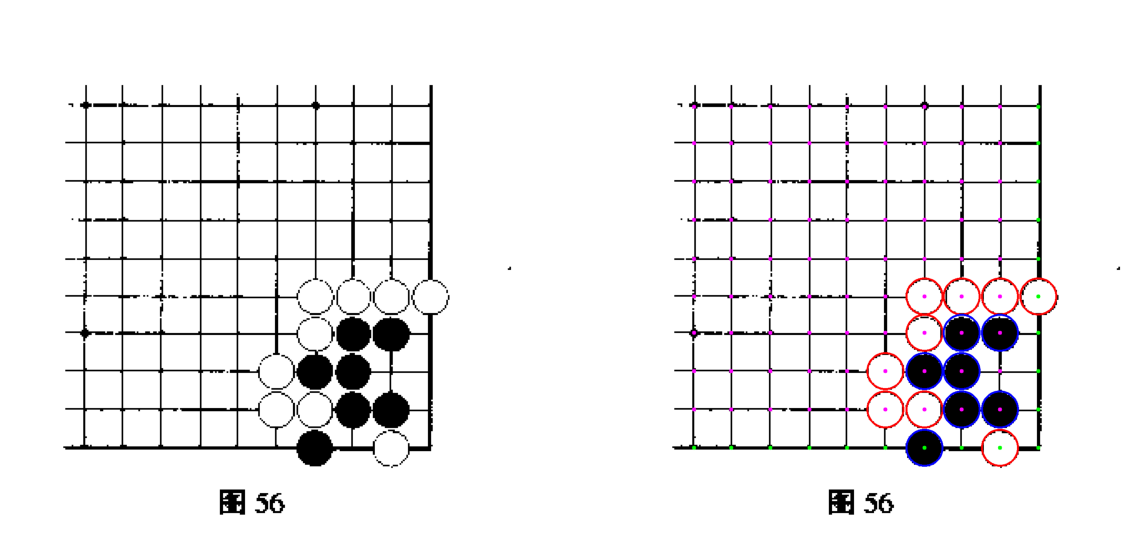

k_2.png


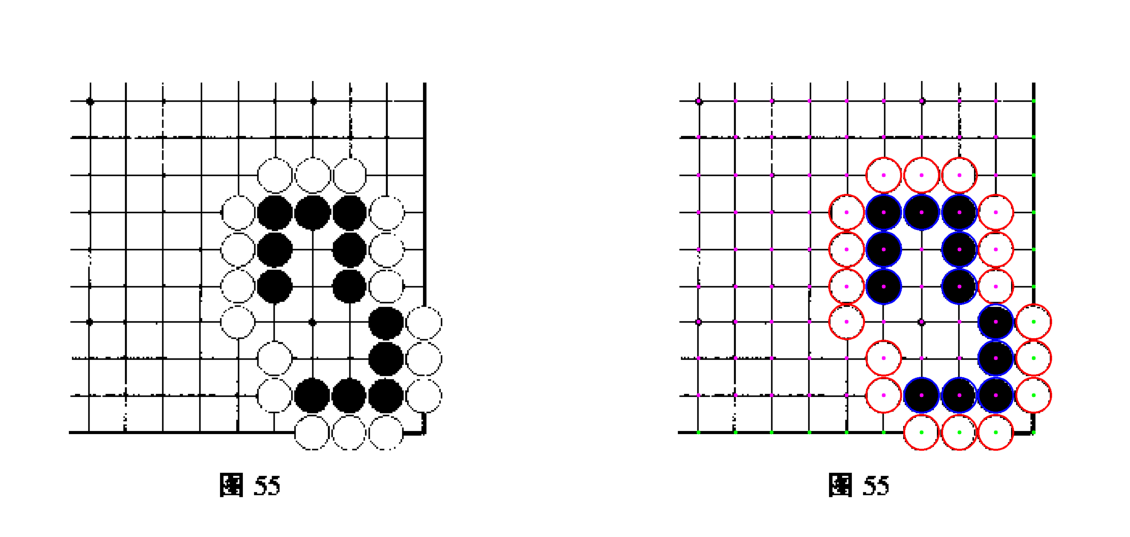

k_3.png


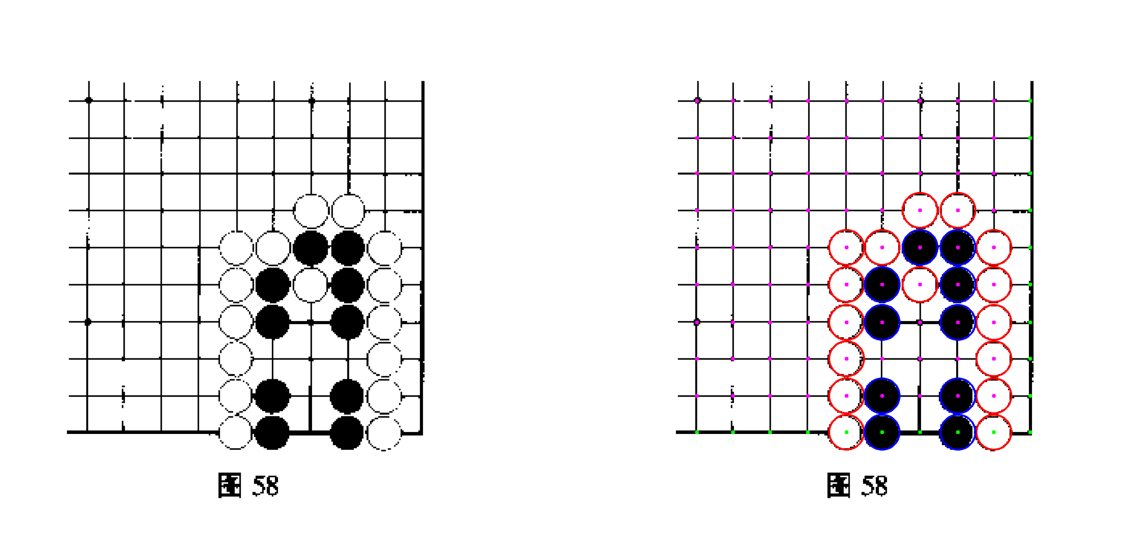

k_1.png


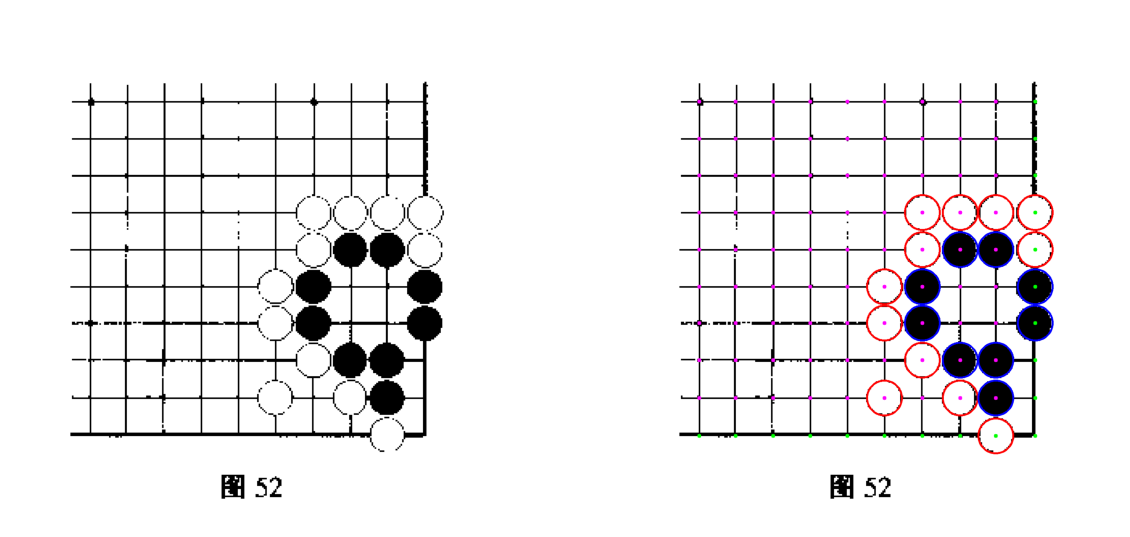

k_0.png


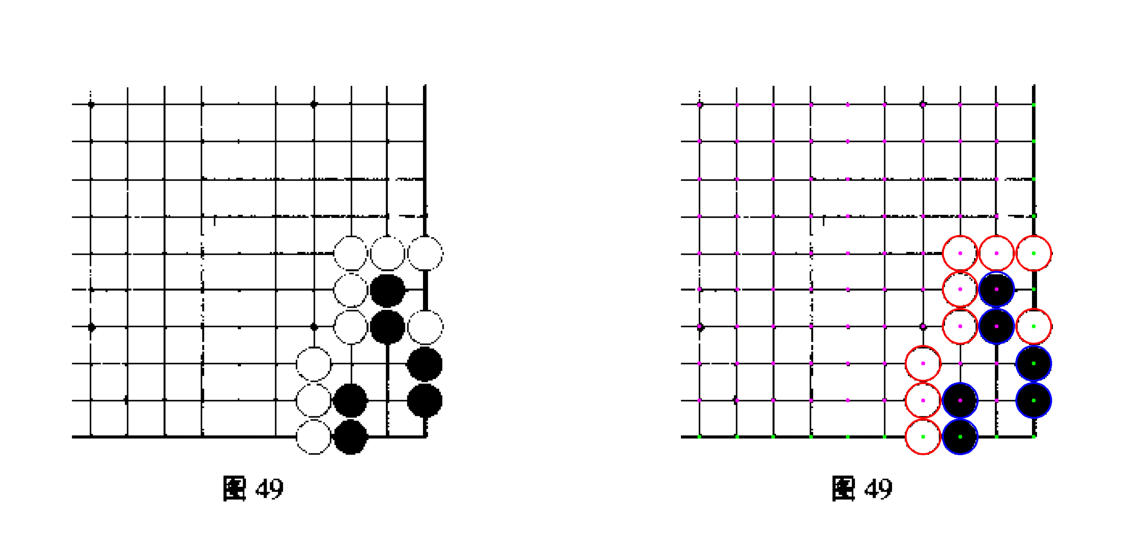

In [91]:
img_files = glob.glob('k_*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize(img)

data/images/chinese/8.png


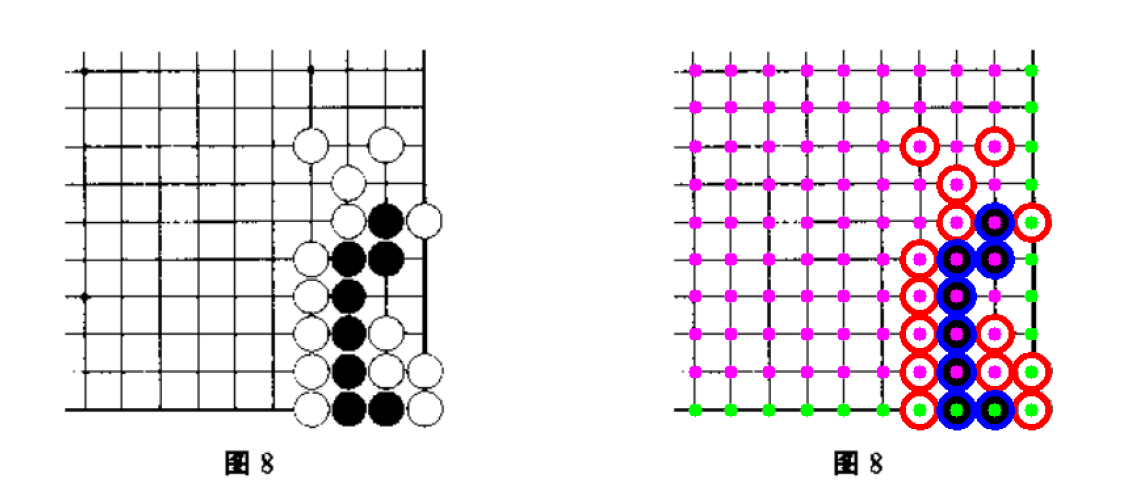

data/images/chinese/9.png


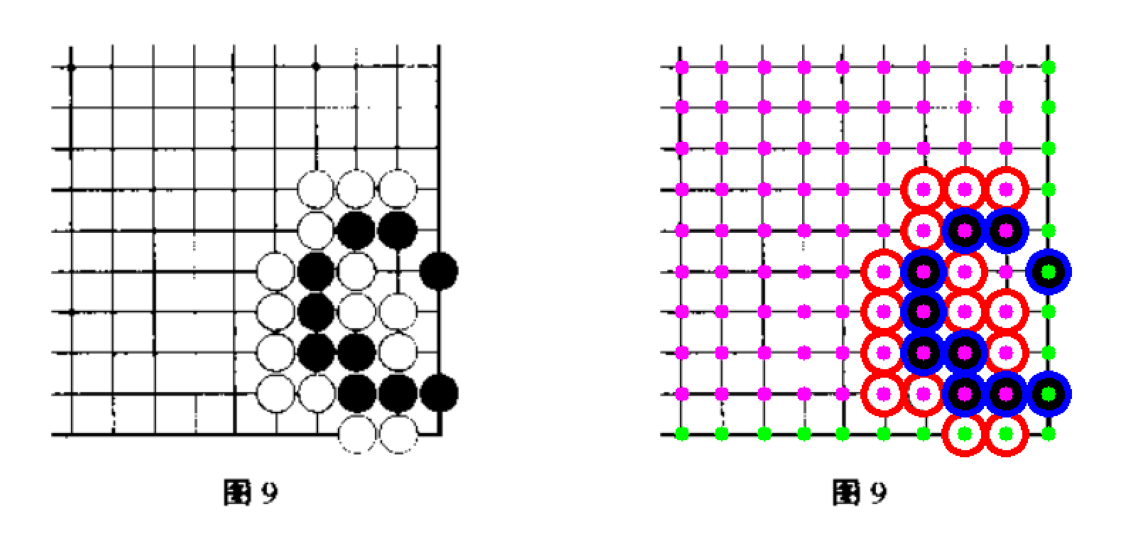

data/images/chinese/12.png


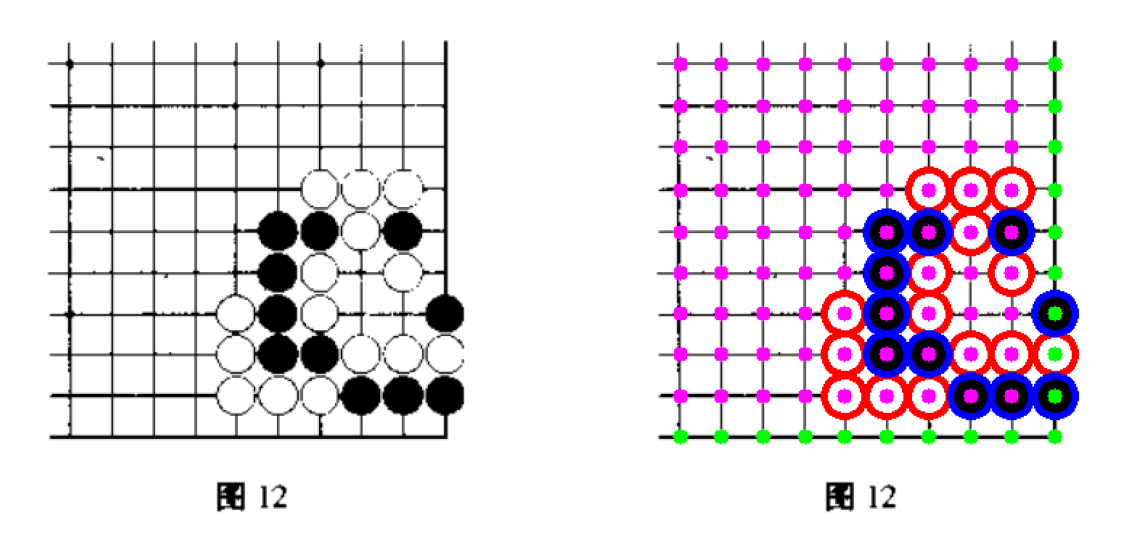

data/images/chinese/11.png


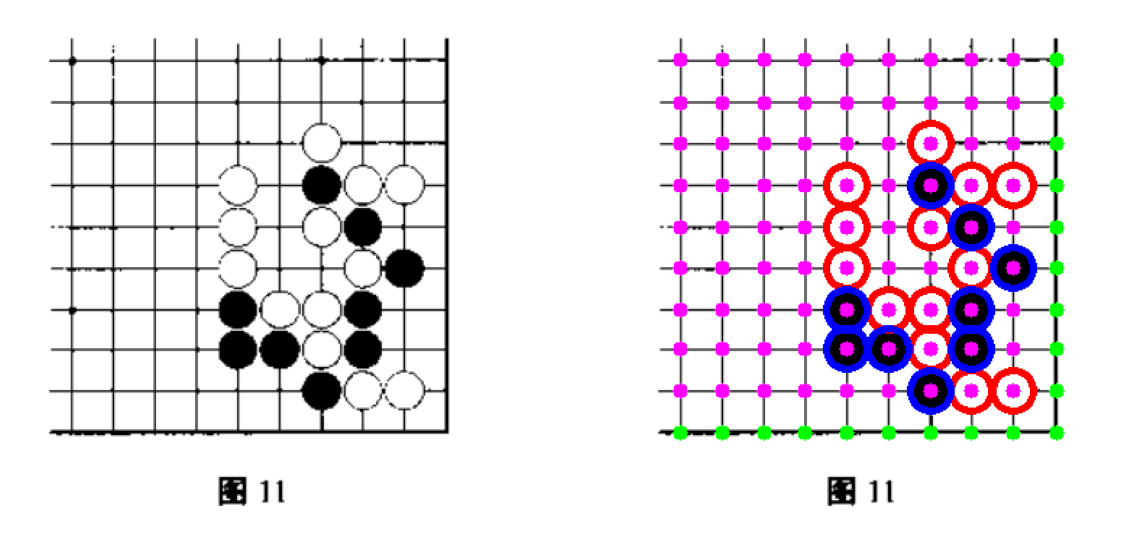

data/images/chinese/10.png


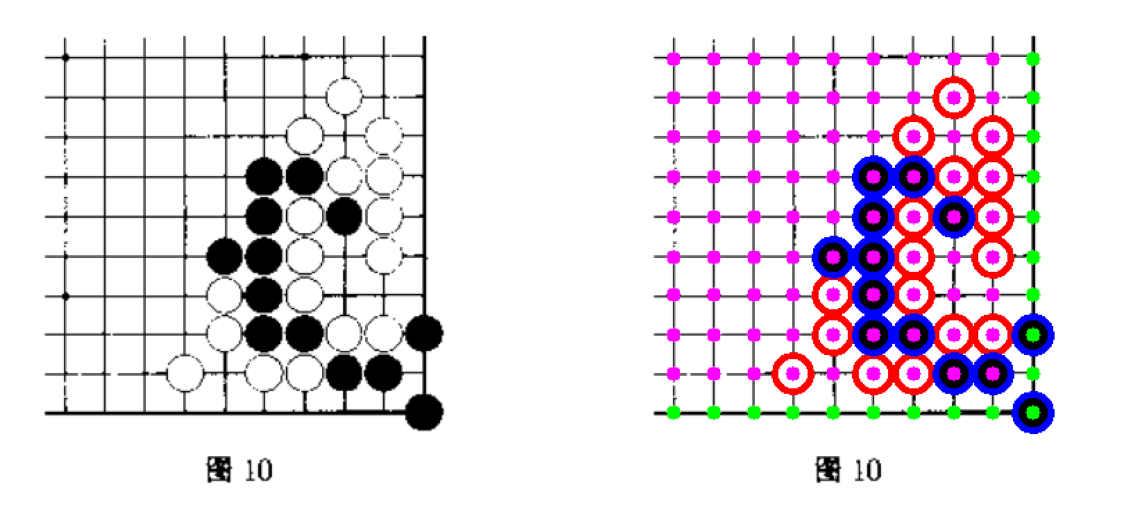

data/images/chinese/4.png


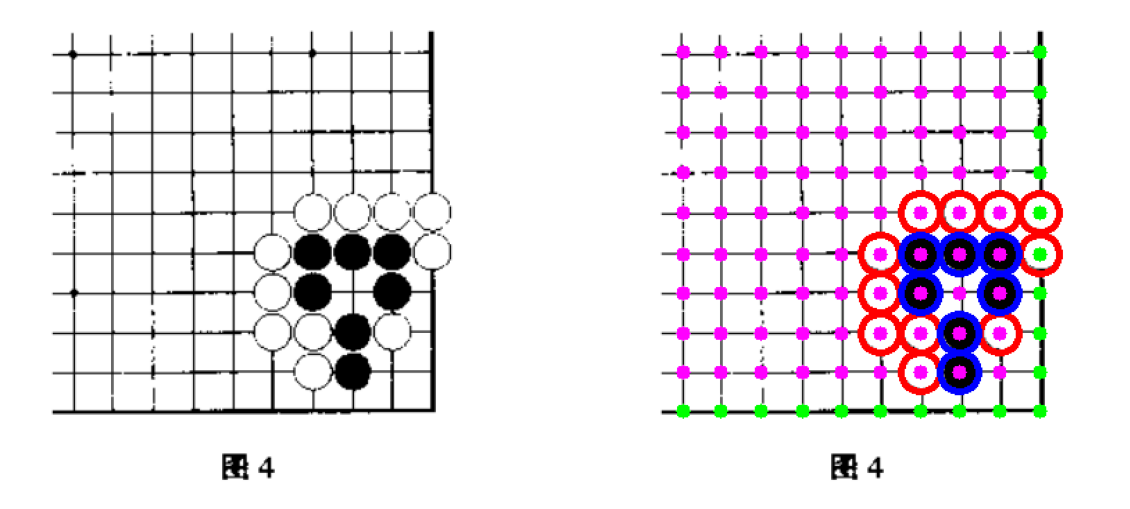

data/images/chinese/5.png


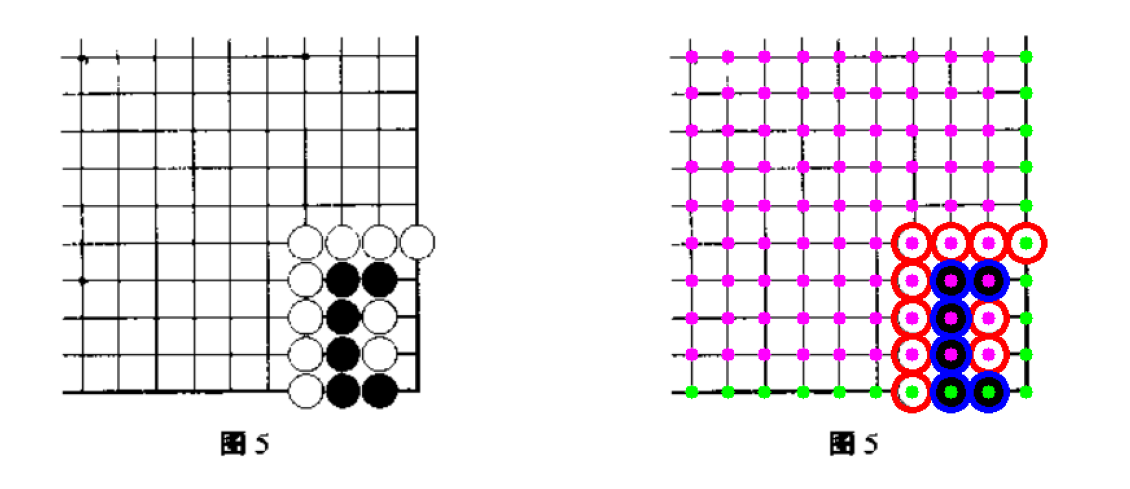

data/images/chinese/7.png


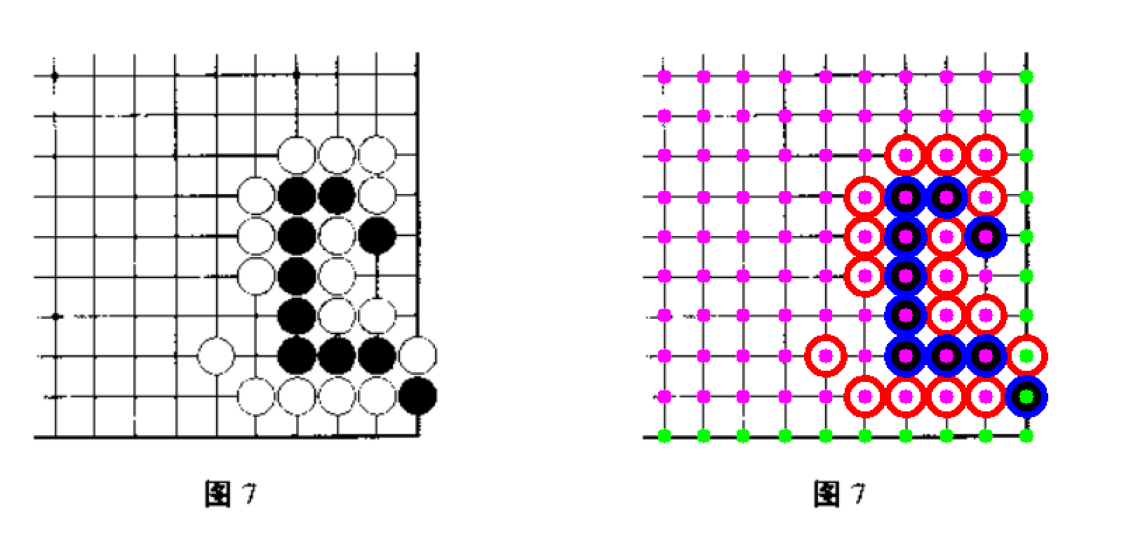

data/images/chinese/6.png


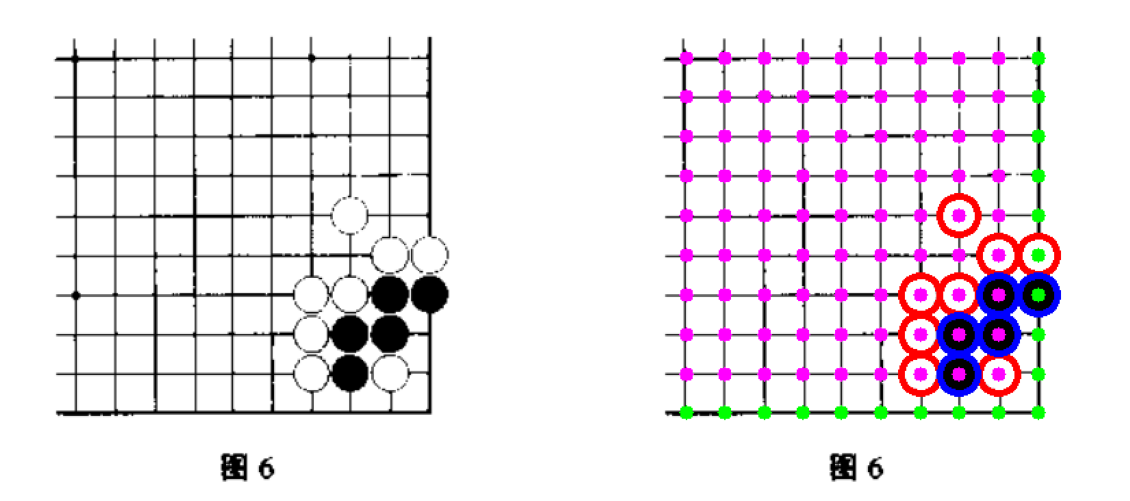

data/images/chinese/2.png


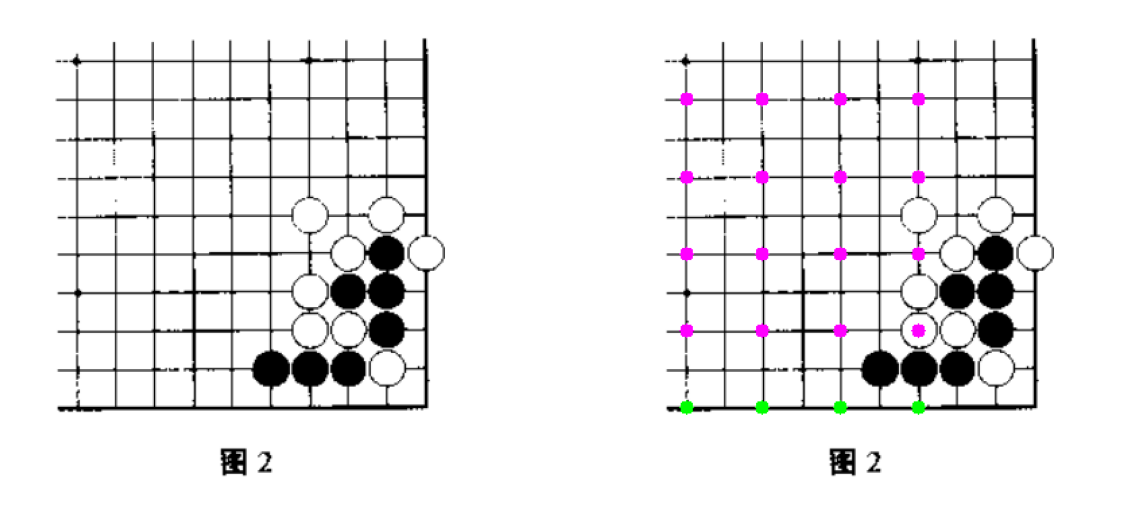

data/images/chinese/3.png


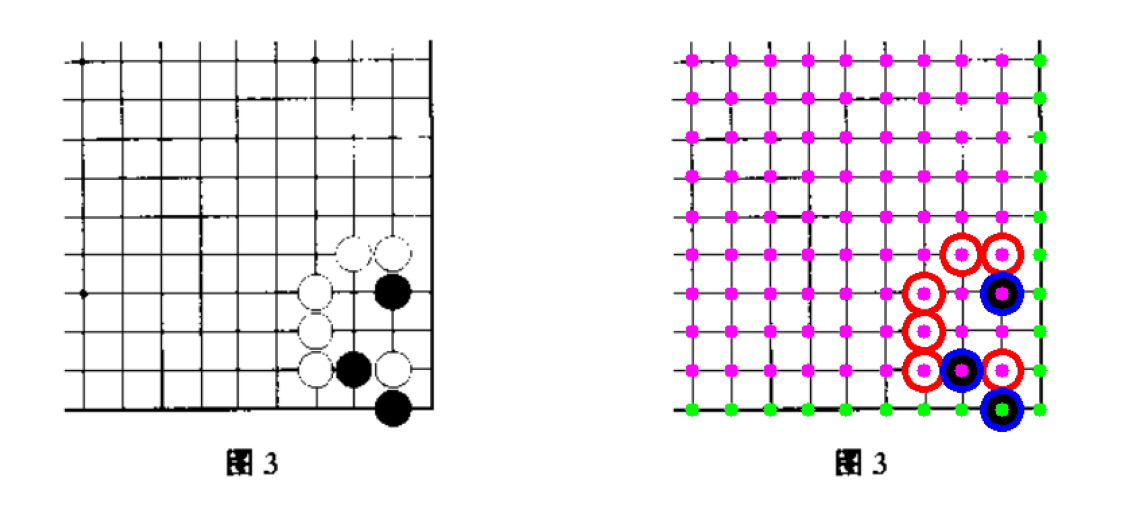

data/images/chinese/1.png


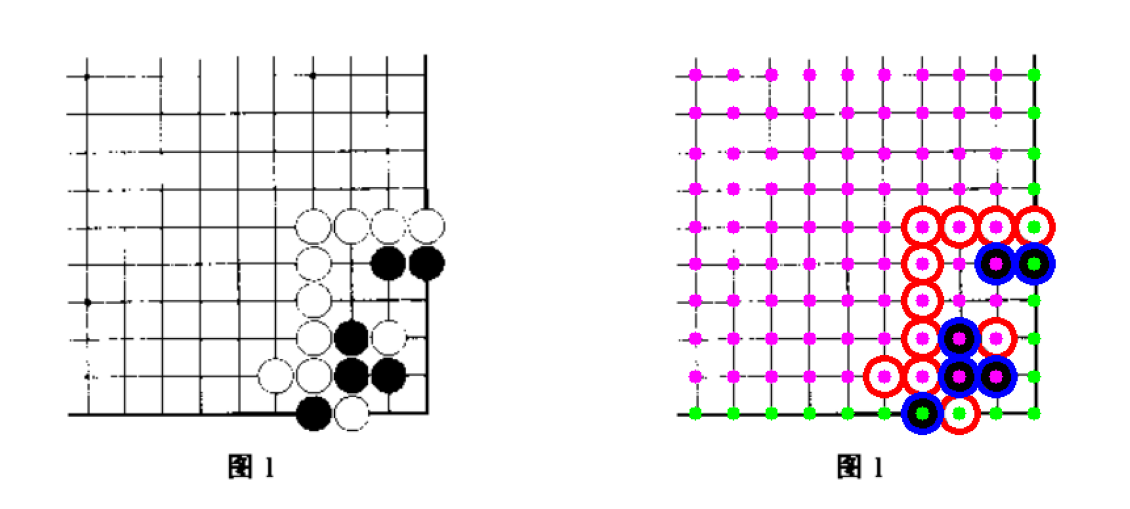

In [30]:
img_files = glob.glob('data/images/chinese/*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize(img)

data/images/cho_chikun/8.png


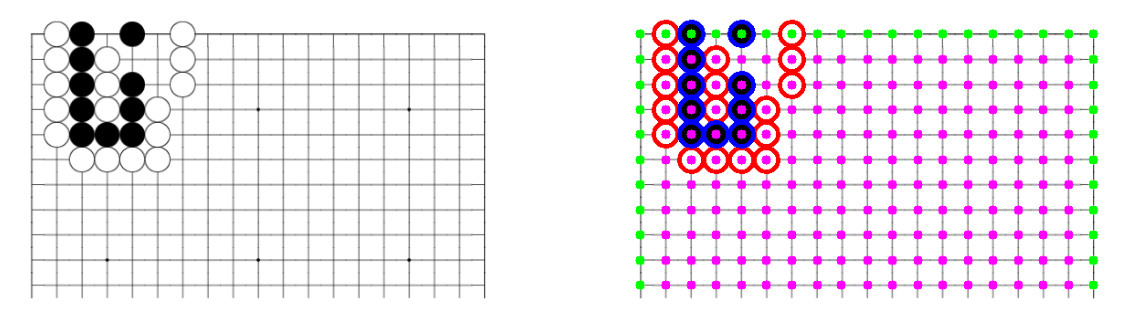

data/images/cho_chikun/4.png


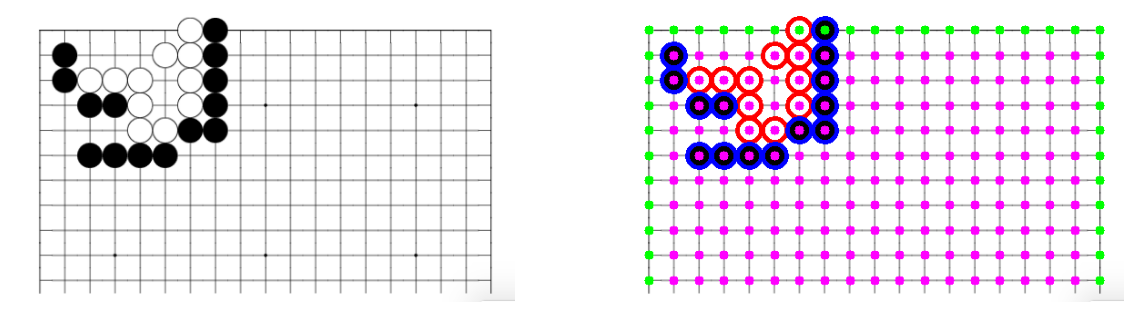

data/images/cho_chikun/5.png


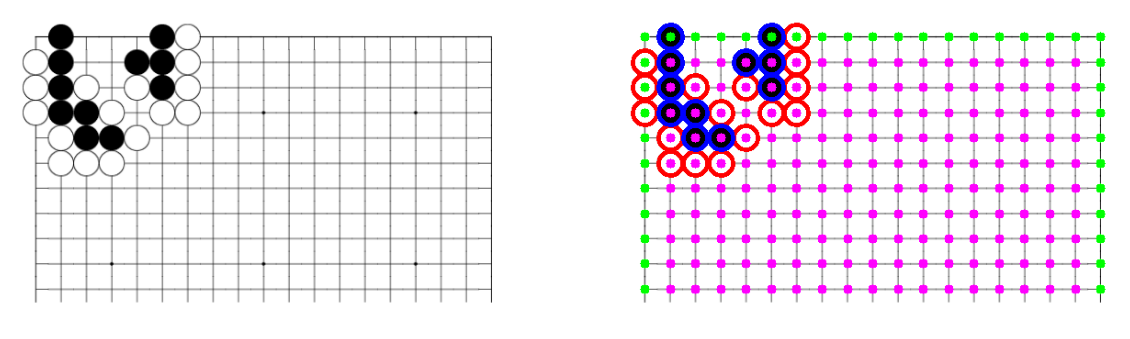

data/images/cho_chikun/7.png


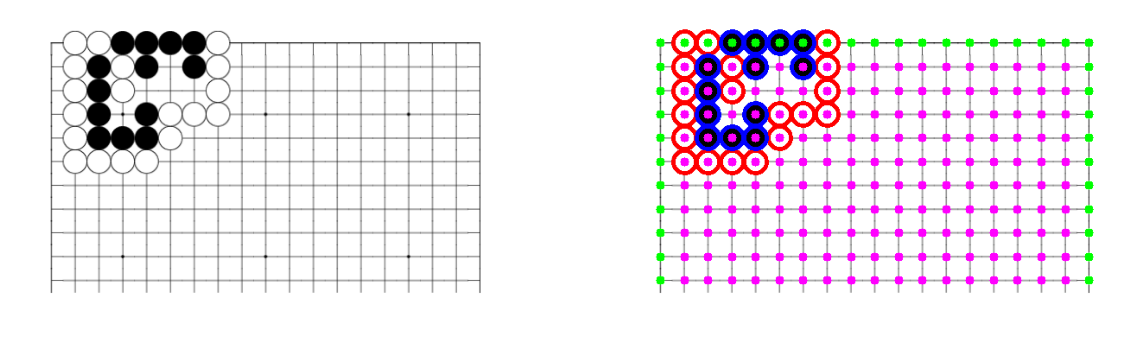

data/images/cho_chikun/6.png


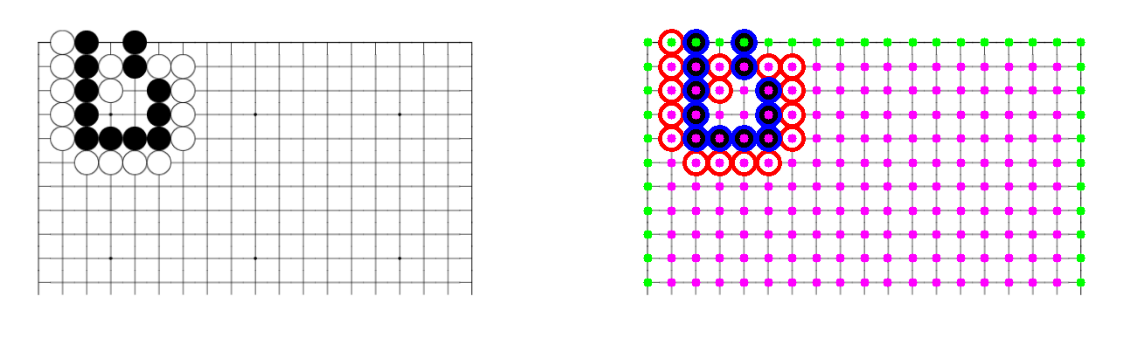

data/images/cho_chikun/2.png


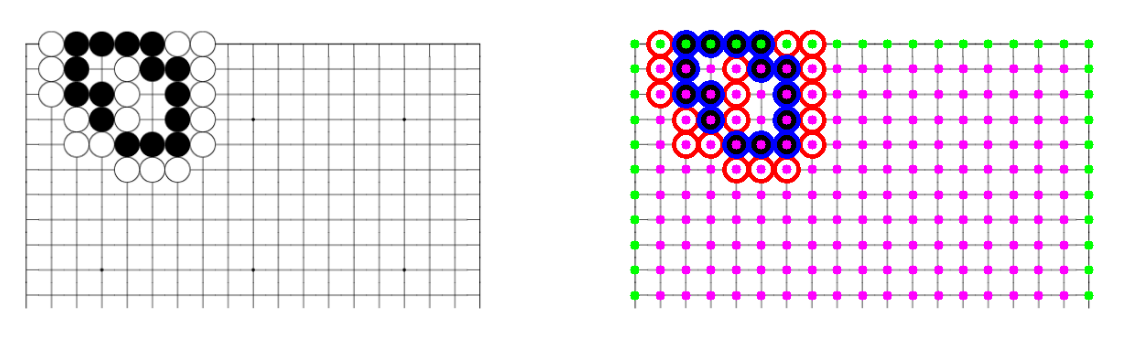

data/images/cho_chikun/3.png


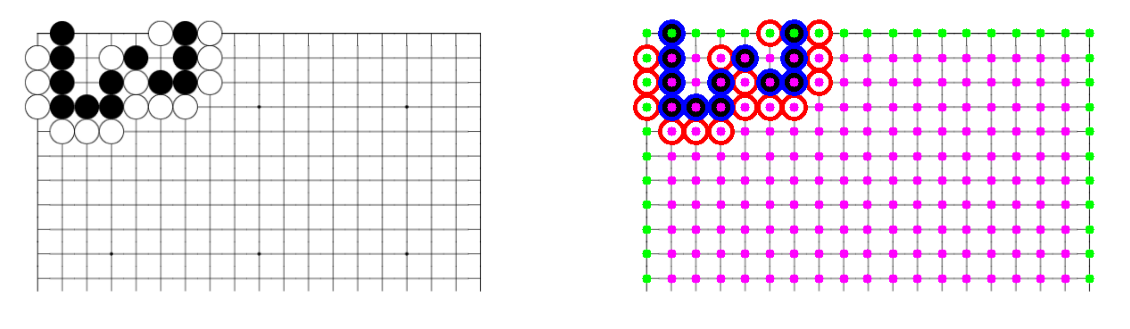

data/images/cho_chikun/1.png


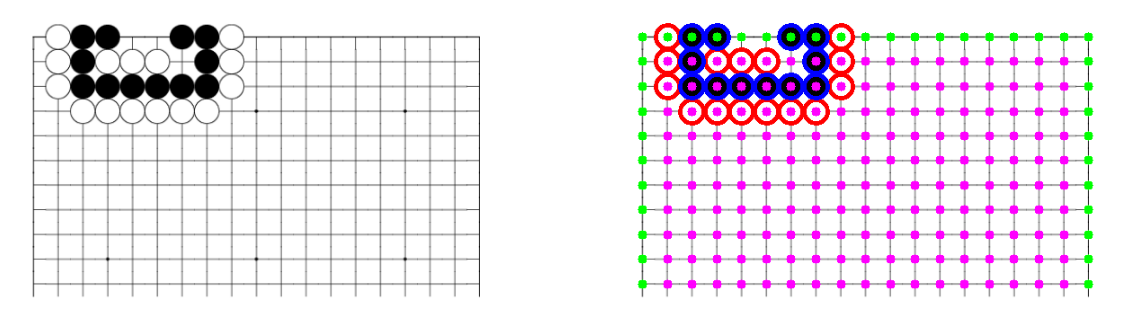

In [34]:
img_files = glob.glob('data/images/cho_chikun/*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize(img)

data/images/p_8.png


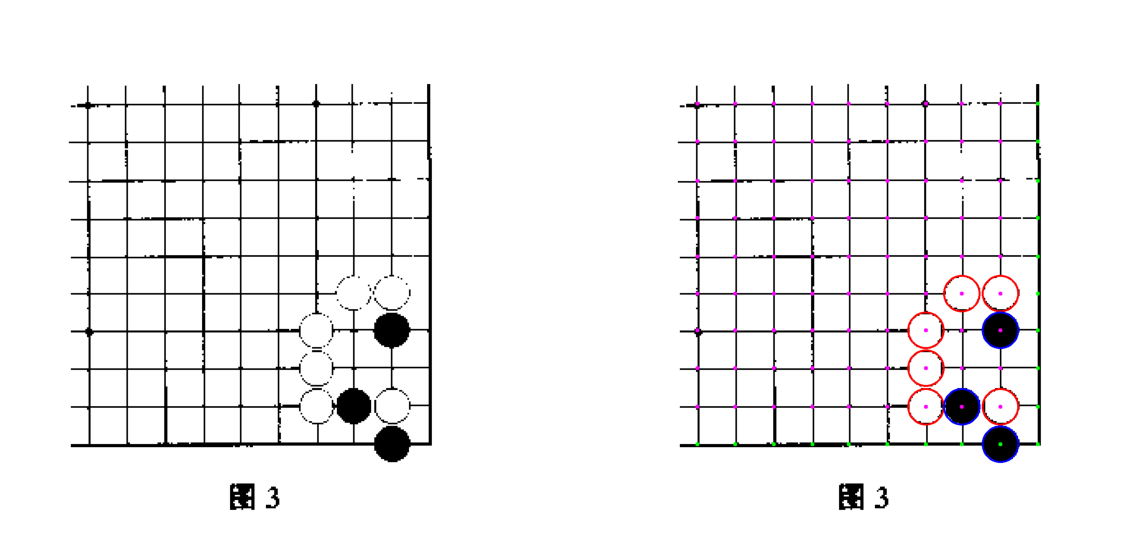

data/images/p_9.png


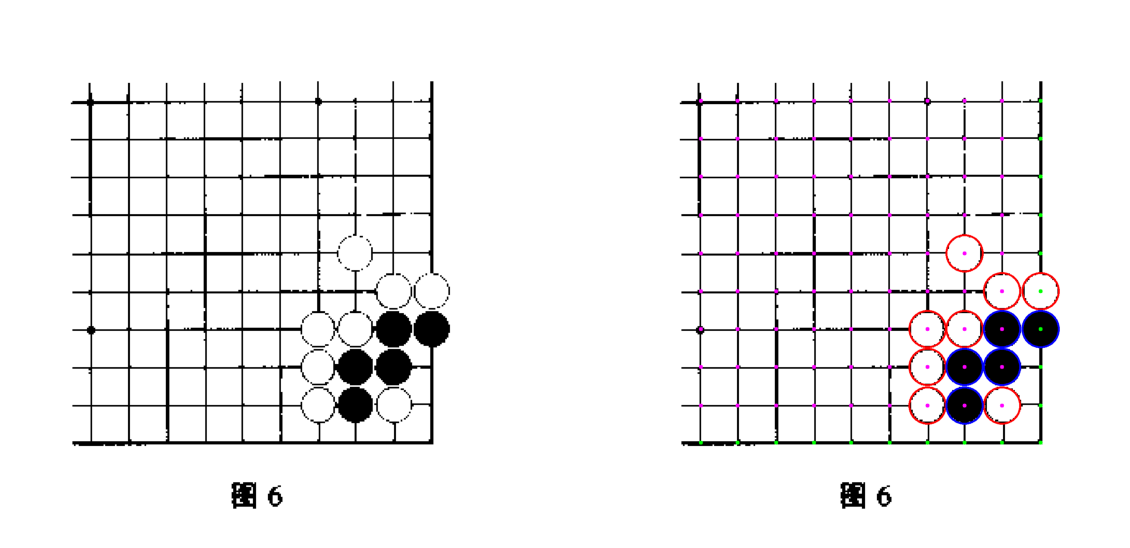

data/images/p_10.png


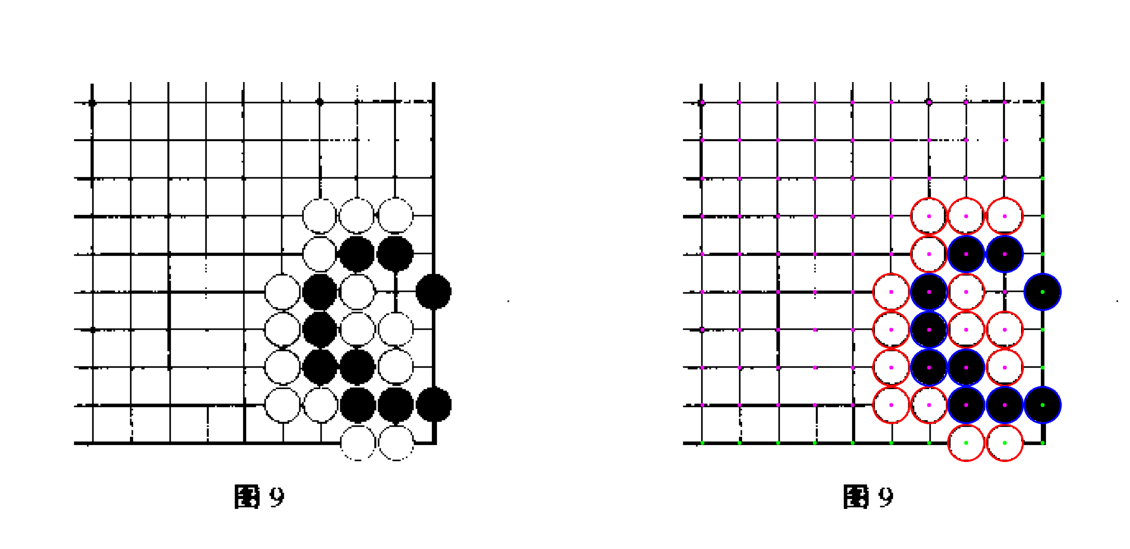

data/images/p_11.png


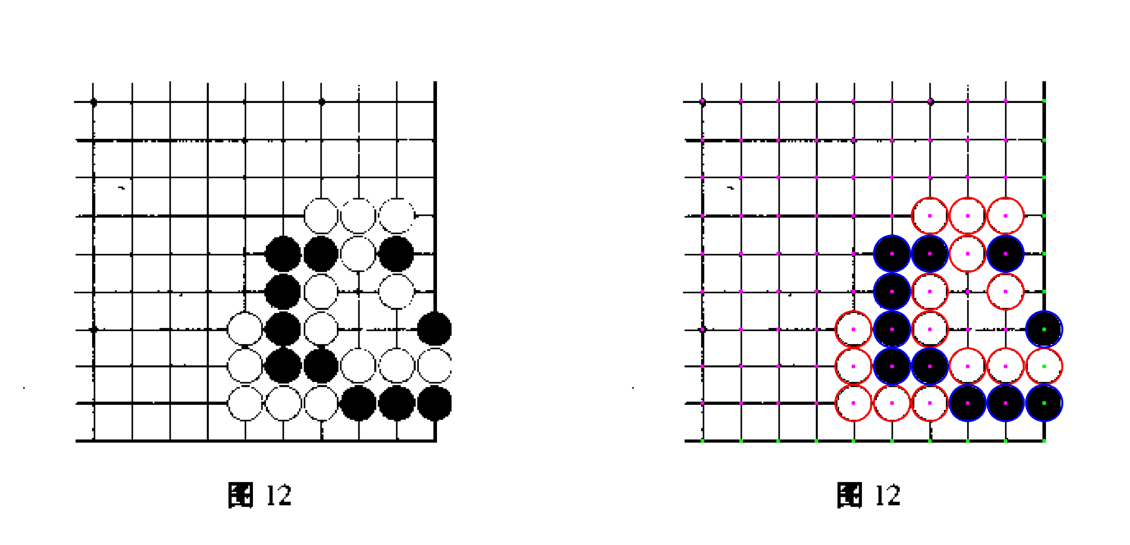

data/images/p_4.png


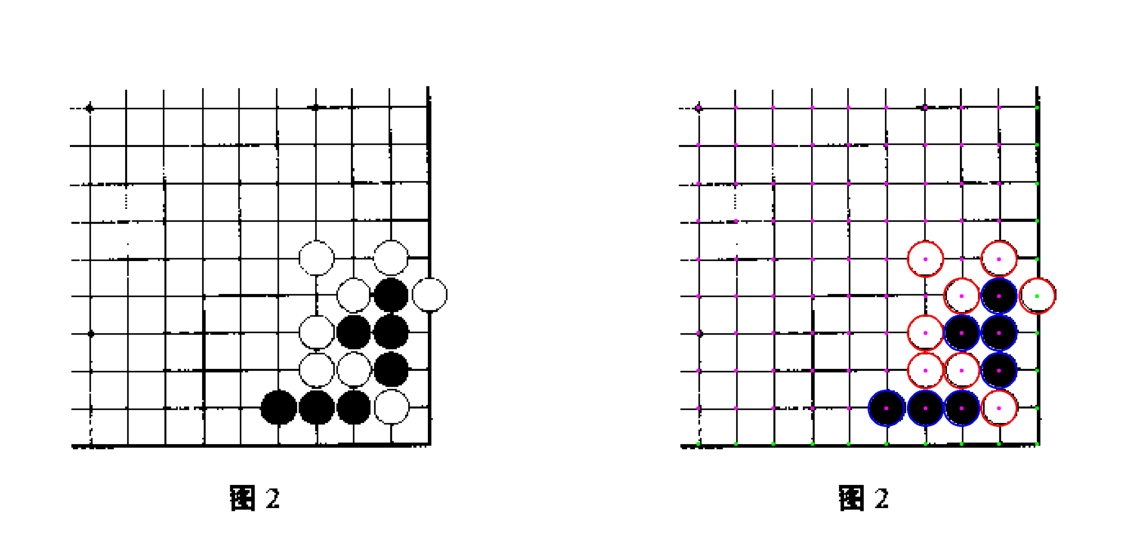

data/images/p_5.png


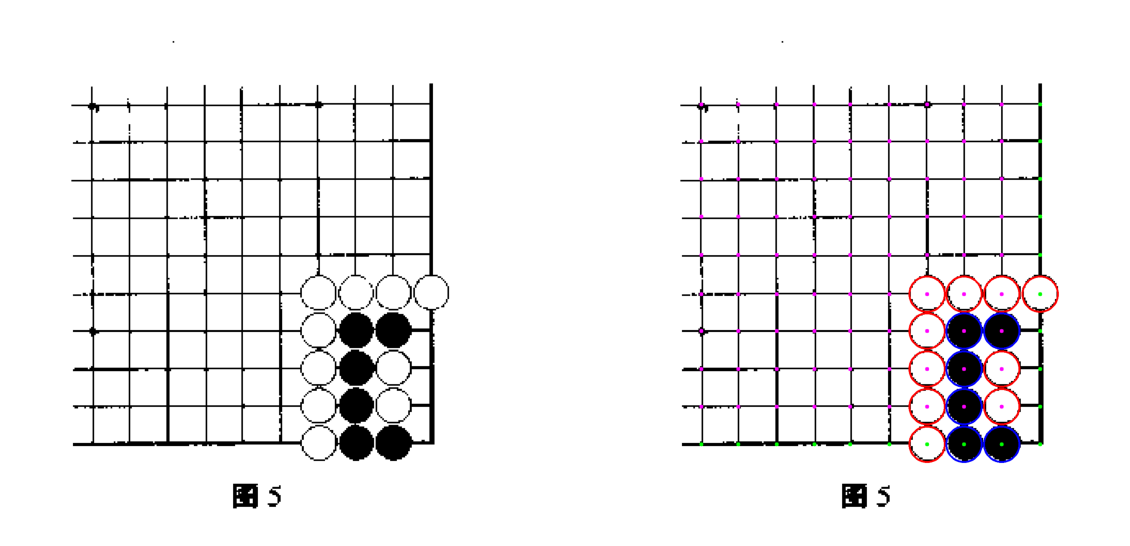

data/images/p_7.png


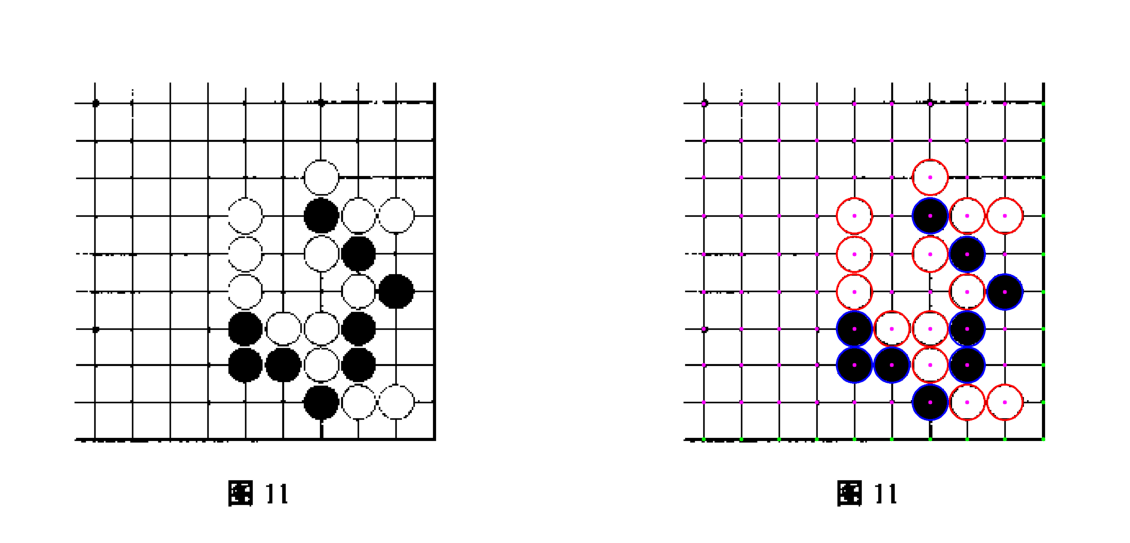

data/images/p_6.png


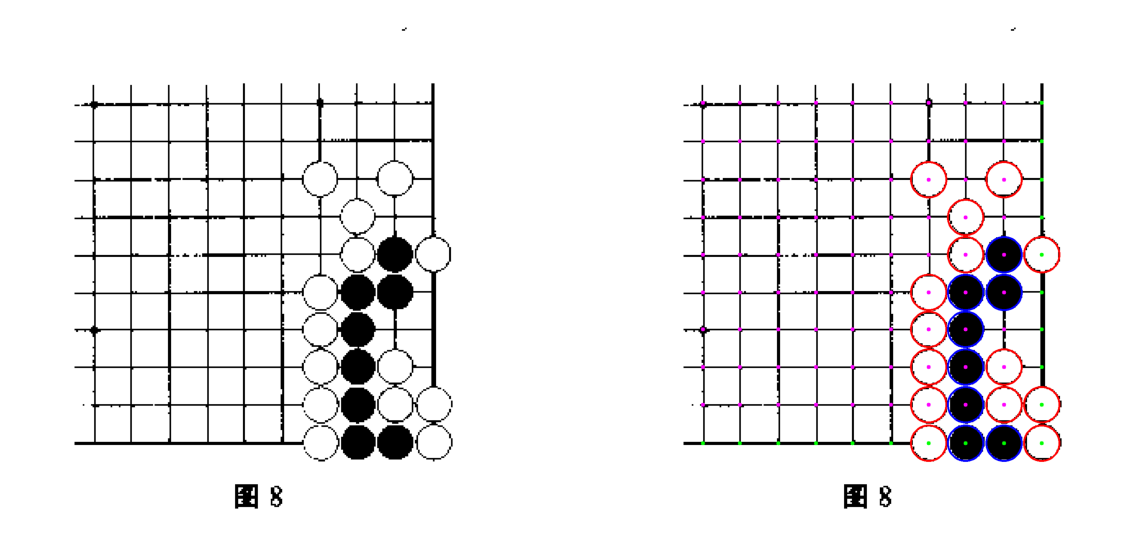

data/images/p_2.png


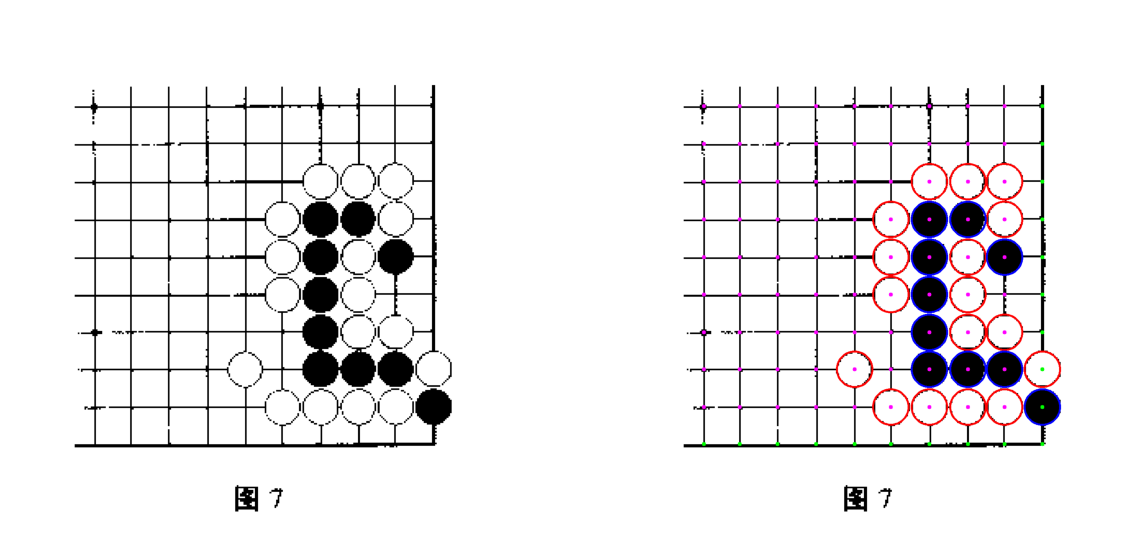

data/images/p_3.png


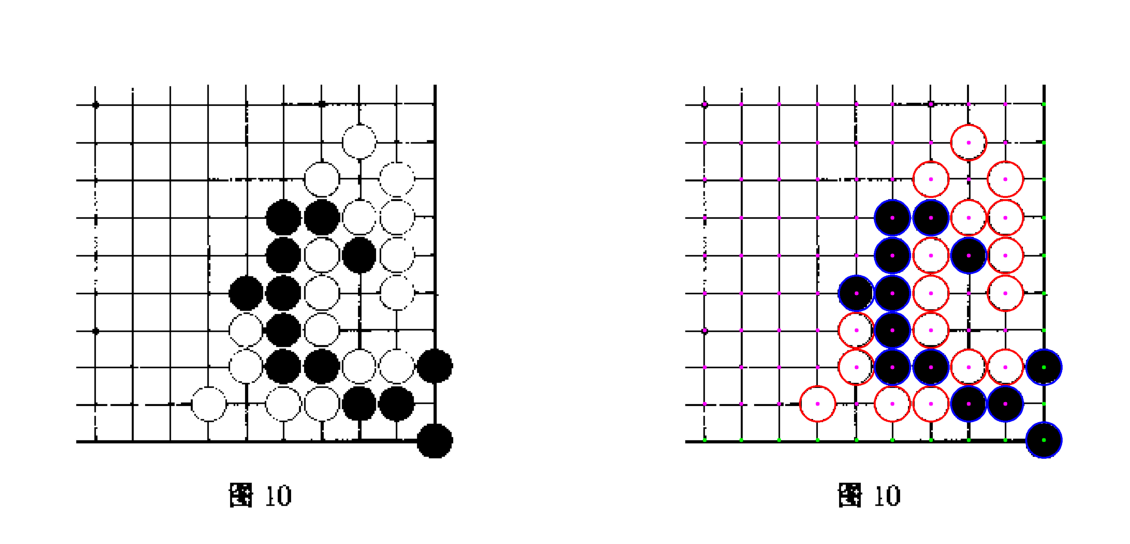

data/images/p_1.png


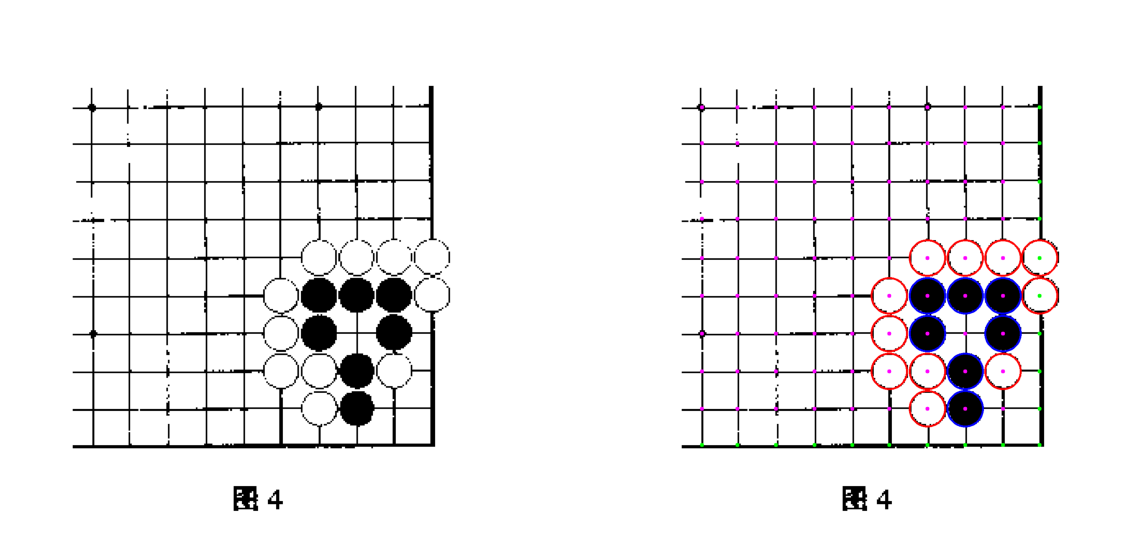

data/images/p_0.png


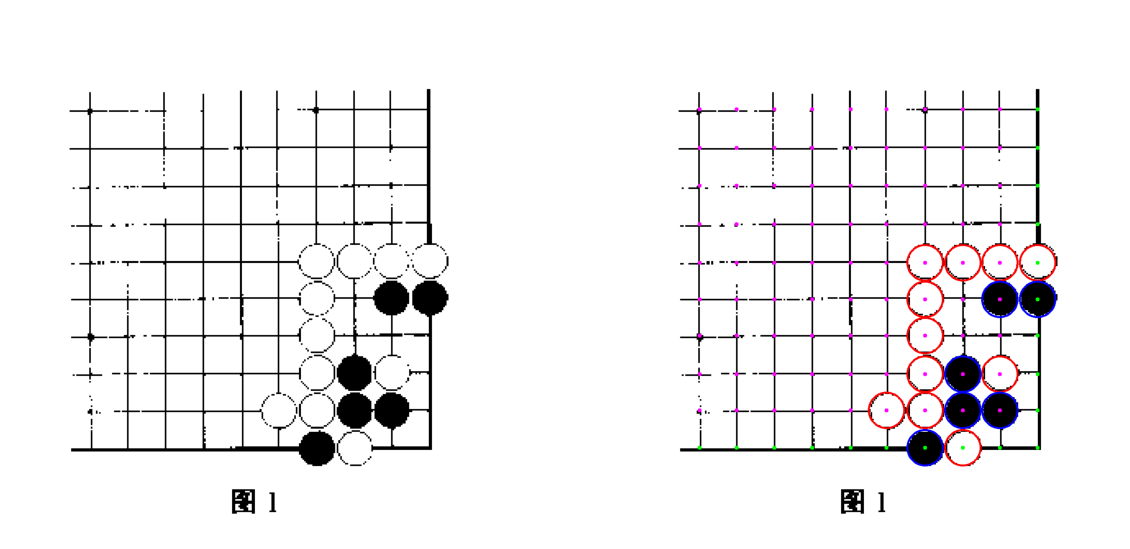

In [92]:
img_files = glob.glob('data/images/p_*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize(img)